# Spatial Prediction using ML in Python

## Create Land Use Classification using Rioxarray & Sklearn

The most common task for remotely sensed data is creating land cover classification. In this tutorial we will walk you through how to train a ML model using raster data. These methods are heavily dependent on the great package [sklearn](https://scikit-learn.org/). To understand the pipeline commands please see their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators).

In [7]:
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.impute import SimpleImputer
import xarray as xr
from rasterio.features import geometry_mask
import rasterio

## Supervised Classification in Python

In the following example we will use Landsat data, some training data to train a supervised sklearn model. In order to do this we first need to have land classifications for a set of points of polygons. In this case we have three polygons with the classes ['water','crop','tree','developed']. The first step is to use `LabelEncoder` to convert these to integer based categories, which we store in a new column called 'lc'.

In [21]:
# Load data files (available in your folder)
l8_raster_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"  # Using available RGBN data
polygons_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg"

# The labels are string names, so here we convert them to integers
le = LabelEncoder()
labels = gpd.read_file(polygons_path)
labels['lc'] = le.fit(labels.name).transform(labels.name)
print(labels)

        name                                           geometry  lc
0      water  POLYGON ((737544.502 -2795232.772, 737544.502 ...   3
1       crop  POLYGON ((742517.658 -2798160.232, 743046.717 ...   0
2       tree  POLYGON ((742435.36 -2801875.403, 742458.874 -...   2
3  developed  POLYGON ((738903.667 -2811573.845, 738926.586 ...   1


We are then going to generate our sklearn pipeline ([see simple tutorial here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)). A pipeline simply allows us to pass a numpy array through a defined set of operations. In this case the data is passed through the following operations:

- `StandardScaler`: [Normalizes](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) all variables by removing the mean and scaling to unit variance
- `PCA`: Calculates [Principal Components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) to reduce dimensionality.
- `GaussianNB`: Fits a [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB) model for a quick classification.

In this example we will fit and predict the model in two steps. The `fit` method returns three objects, a transformed version of the original dataset `X` that can be used by sklearn, `Xy` a tuple containing the data used for training (X,y) where any data outside the polygons is removed, and the trained pipeline `clf` object.

In [22]:
def fit_raster(raster_path, pipeline, labels, col='lc'):
   """Extract training data from raster and fit pipeline."""
   # Resample to 150m and get CRS
   with rxr.open_rasterio(raster_path) as src:
       src = src.rio.reproject(src.rio.crs, resolution=150)
       data = src.to_numpy()
       transform = src.rio.transform()
       height, width = src.shape[1], src.shape[2]
       raster_crs = src.rio.crs
   
   # Reproject polygons to match raster CRS
   labels = labels.to_crs(raster_crs)
   
   # Reshape to (samples, bands)
   X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
   
   # Extract pixels and labels per polygon
   X_train = []
   y_train = []
   for idx, row in labels.iterrows():
       geom = row.geometry
       label = row[col]
       mask = geometry_mask([geom], (height, width), transform, invert=True)
       X_train.append(X[mask.ravel()])
       y_train.append(np.full(np.sum(mask), label, dtype=int))
   
   # Concatenate training data
   X_train = np.concatenate(X_train)
   y_train = np.concatenate(y_train)
   
   if len(X_train) == 0:
       raise ValueError("No pixels found under label polygons")
   if len(X_train) != len(y_train):
       raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
   
   # Fit pipeline
   pipeline.fit(X_train, y_train)
   
   return X, (X_train, y_train), pipeline

In order to fit and predict to our original data in one step, we simply use `fit_predict`:

Final labels:
        name  lc
0      water   3
1       crop   0
2       tree   2
3  developed   1


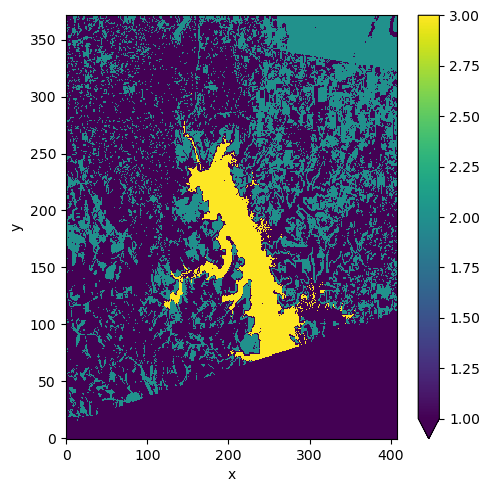

In [37]:
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd

# Load and process labels in one go
l8_raster_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
polygons_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg"

labels = gpd.read_file(polygons_path)
le = LabelEncoder()
labels['lc'] = le.fit_transform(labels['name'])

print("Final labels:")
print(labels[['name', 'lc']])

fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
y = fit_predict_raster(l8_raster_path, pl, labels, col='lc')
y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

Processing label: 3, type: <class 'int'>
Processing label: 0, type: <class 'int'>
Processing label: 2, type: <class 'int'>
Processing label: 1, type: <class 'int'>


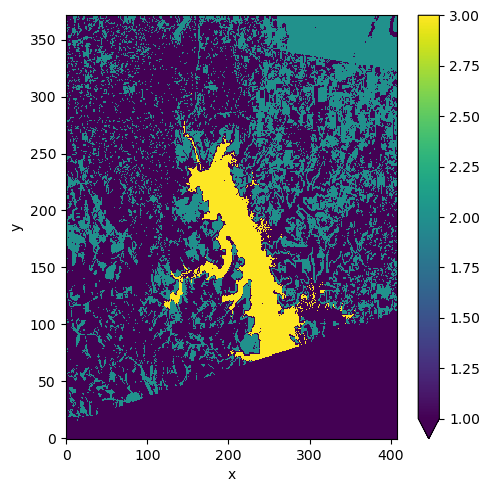

In [39]:
# Add debugging to your function
def fit_predict_raster_debug(raster_path, pipeline, labels=None, col='lc'):
    """Combine fit and predict for classification with debugging"""
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rxr.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        height, width = src.shape[1], src.shape[2]
        transform = src.rio.transform()
    
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    if labels is not None:
        X_train = []
        y_train = []
        for idx, row in labels.iterrows():
            geom = row.geometry
            label = row[col]
            print(f"Processing label: {label}, type: {type(label)}")
            mask = geometry_mask([geom], (height, width), transform, invert=True)
            if np.sum(mask) > 0:  # Only add if mask has pixels
                X_train.append(X[mask.ravel()])
                y_train.append(np.full(np.sum(mask), int(label), dtype=int))
        
        if len(X_train) == 0:
            raise ValueError("No pixels found under label polygons")
            
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X)
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(y_pred, coords={'y': np.arange(height), 'x': np.arange(width)}, dims=['y', 'x'])
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(transform)
    return y_da

# Test with debug version
fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
y = fit_predict_raster_debug(l8_raster_path, pl, labels, col='lc')
y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

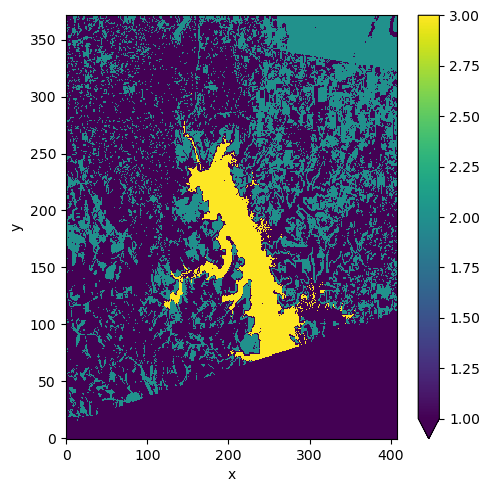

In [42]:
import os
from pathlib import Path
import rasterio
import rioxarray as rxr
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder

def fit_predict_raster(raster_path, pipeline, labels=None, col='lc'):
    """Combine fit and predict for classification"""
    with rasterio.open(raster_path) as ds:
        profile = ds.profile
    
    with rxr.open_rasterio(raster_path) as src:
        src = src.rio.reproject(src.rio.crs, resolution=150)
        data = src.to_numpy()
        height, width = src.shape[1], src.shape[2]
        transform = src.rio.transform()
    
    X = data.transpose(1, 2, 0).reshape(-1, data.shape[0])
    
    if labels is not None:
        X_train = []
        y_train = []
        for idx, row in labels.iterrows():
            geom = row.geometry
            label = row[col]
            mask = geometry_mask([geom], (height, width), transform, invert=True)
            X_train.append(X[mask.ravel()])
            y_train.append(np.full(np.sum(mask), label, dtype=int))
        
        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        
        if len(X_train) == 0:
            raise ValueError("No pixels found under label polygons")
        if len(X_train) != len(y_train):
            raise ValueError(f"Inconsistent samples: X_train={len(X_train)}, y_train={len(y_train)}")
        
        pipeline.fit(X_train, y_train)
    else:
        pipeline.fit(X)
    
    y_pred = pipeline.predict(X)
    y_pred = y_pred.reshape(height, width)
    y_da = xr.DataArray(y_pred, coords={'y': np.arange(height), 'x': np.arange(width)}, dims=['y', 'x'])
    y_da.rio.write_crs(profile['crs'])
    y_da.rio.write_transform(transform)
    return y_da

# Fix file paths
base_path = Path("../../pygis/data/").resolve()
l8_raster_path = str(base_path / "LC08_L1TP_224078_20200518_20200518_01_RT.TIF")
polygons_path = str(base_path / "LC08_L1TP_224078_20200518_20200518_01_RT_polygons.gpkg")

# Verify files exist
assert os.path.exists(l8_raster_path), f"File not found: {l8_raster_path}"
assert os.path.exists(polygons_path), f"File not found: {polygons_path}"

# Load labels and CREATE the 'lc' column
labels = gpd.read_file(polygons_path)
le = LabelEncoder()
labels['lc'] = le.fit_transform(labels['name'])

fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
y = fit_predict_raster(l8_raster_path, pl, labels, col='lc')
y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

Raster CRS: EPSG:32621
Raster bounds: BoundingBox(left=717345.0, bottom=-2832795.0, right=778575.0, top=-2776995.0)
Polygons CRS: EPSG:32621
Polygons bounds: [  737544.50243024 -2811848.87361365   743164.28574596 -2795232.77178369]


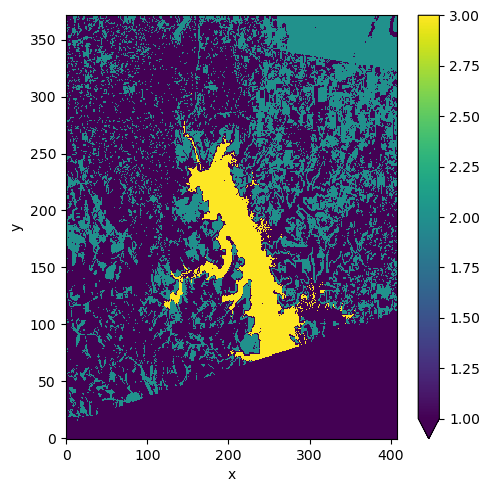

In [45]:
# Check coordinate systems and bounds
with rasterio.open(l8_raster_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster bounds: {src.bounds}")

print(f"Polygons CRS: {labels.crs}")
print(f"Polygons bounds: {labels.total_bounds}")

# Reproject polygons to match raster CRS
with rasterio.open(l8_raster_path) as src:
    labels_reprojected = labels.to_crs(src.crs)

fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
y = fit_predict_raster(l8_raster_path, pl, labels_reprojected, col='lc')
y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Unsupervised Classification in Python

Unsupervised classification takes a different approach. Here we don't have to provide examples of different land cover types. Instead we rely on the algorithm to identify distinct clusters of similar data, and apply a unique label to each cluster. For instance, if we are talking about land cover water and trees are going to look very different. Water reflects more blue and absorbs all the near infrared, while trees reflect little blue and reflect lots of near infrared. Therefore water and trees should 'cluster' together when plotted out according to their different blue and near infrared reflectances. These clusters will be assigned a unique value to each pixel, e.g. water will be assigned 1 and trees 2. Later, the end user will need to go back and assign the label to each numbered cluster, e.g. water=1, trees=2.

In this example we will use [kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to do our clustering. To run we need to decide apriori how many clusters we want to identify. Typically you want to roughly double the number of expected classes and then recombine them later into the desired labels. This helps to better understand and categorize the variation in your image.

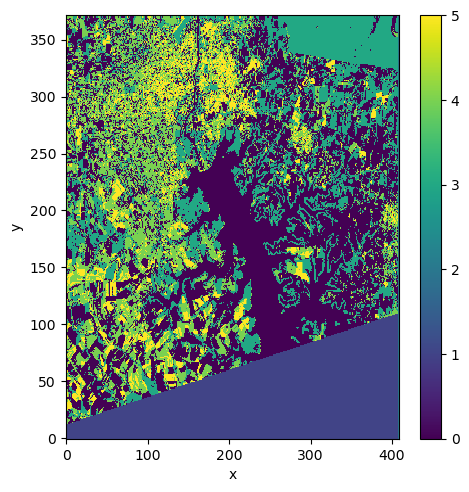

In [47]:
cl = Pipeline([('clf', KMeans(n_clusters=6, random_state=0))])

fig, ax = plt.subplots(dpi=100, figsize=(5, 5))

# Fit_predict unsupervised classifier
y = fit_predict_raster(l8_raster_path, cl)  # No labels parameter = unsupervised
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

In this case we can see that it effectively labels different clusters of data, and now it is up to us to determine which clusters should be categorized as water, trees, and fields etc.

## Spatial prediction with time series stack using Rioxarray & Sklearn

If you have a stack of time series data it is simple to apply the same method as we described previously, except we need to open multiple images and stack them. Note we are just pretending we have two dates of Landsat imagery here.

<xarray.DataArray (y: 372, x: 409)> Size: 1MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 2, ..., 2, 2, 1],
       [1, 1, 1, ..., 2, 2, 1],
       [2, 1, 1, ..., 2, 2, 1]], shape=(372, 409))
Coordinates:
  * y        (y) int64 3kB 0 1 2 3 4 5 6 7 8 ... 364 365 366 367 368 369 370 371
  * x        (x) int64 3kB 0 1 2 3 4 5 6 7 8 ... 401 402 403 404 405 406 407 408


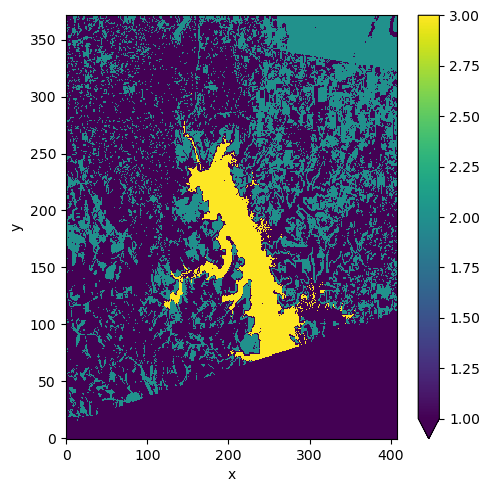

In [49]:
fig, ax = plt.subplots(dpi=100, figsize=(5, 5))

# Stack rasters along band dimension (simulating time series)
with rxr.open_rasterio(l8_raster_path) as src1:
    src1 = src1.rio.reproject(src1.rio.crs, resolution=150)
with rxr.open_rasterio(l8_raster_path) as src2:
    src2 = src2.rio.reproject(src2.rio.crs, resolution=150)

# Stack along band dimension
src_stack = xr.concat([src1, src2], dim='band')

# Save stacked raster to temporary file for processing
stacked_path = 'stacked_raster.tif'
src_stack.rio.to_raster(stacked_path)

y = fit_predict_raster(stacked_path, pl, labels, col='lc')
print(y)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

If you want to do more sophisticated model tuning using sklearn it is also possible to break up your fit and predict steps as follows:

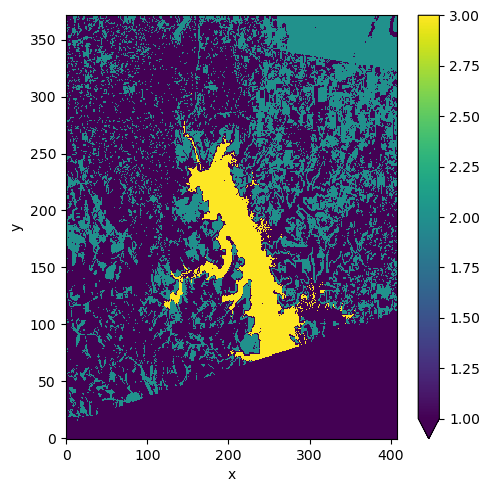

In [51]:
fig, ax = plt.subplots(dpi=100, figsize=(5, 5))

X, Xy, clf = fit_raster(l8_raster_path, pl, labels, col="lc")
y = predict_raster(l8_raster_path, X, clf)
y.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

## Cross-validation and Hyperparameter Tuning with Spatial Prediction

One of the most important parts of successfully building a model is a careful assessment of model performance. To do this we will leverage some of sklearn built in tools. One of the most common cross-validation methods is called k-fold, where your data is broken in to independent sets of training and testing data multiple times. The ability of the model - trained on the 'training' data - to predict the outcome of the 'testing' data multiple times. We can then have a measure of how well our model will work on data it has never seen before.

In this case we are going to use our supervised classification pipeline `pl` from earlier. And we will use [kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) to do [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

We often also need to [hyper-parameter tune](https://scikit-learn.org/stable/modules/grid_search.html) our model. In this case we will see if we need to keep 1, 2, or 3 [pca](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) components. We might also want to experiment with whether scaling the data range impacts our performance with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) by changing whether or not variables are divided by their standard deviation.

To do hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) in a pipeline we need to set up the 'parameter-grid'. This part can be a little confusing. To help us let's isolate the `Pipeline` and `param_grid` from the example below:

```python
pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GaussianNB())])
param_grid={"scaler__with_std":[True,False],
            "pca__n_components": [1, 2, 3]
           }
```

Notice that each step in the pipeline is labeled (e.g. 'scaler', 'pca', 'clf'). To try out different parameters for each step we are going to need to reference them by name in our `param_grid` dictionary. The dictionary follows this convention:

`(step_name)__(parameter_name):[value_1, value2]`

So `"pca__n_components": [1, 2, 3]` says that for the `pca` step of the pipeline, we will try out three different values for the parameter `n_components`, allowing us to choose the one that performs best at predicting our 'testing' data.

CV Results keys: ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_pca__n_components']
Best score: 0.6666666666666666
Best params: {'pca__n_components': 1, 'scaler__with_std': True}


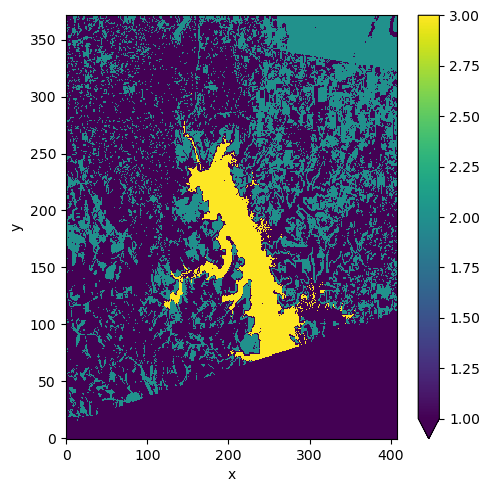

In [55]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress the specific sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics._classification')

pl = Pipeline([
   ('scaler', StandardScaler()),
   ('pca', PCA()),
   ('clf', GaussianNB())
])
gridsearch = GridSearchCV(
   pl, 
   cv=KFold(n_splits=3), 
   scoring='balanced_accuracy',
   param_grid={
       "scaler__with_std": [True, False],
       "pca__n_components": [1, 2, 3]
   }
)
fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
# Fit a model to get Xy used to train model
X, Xy, pipe = fit_raster(l8_raster_path, pl, labels, col="lc")
# Fit cross validation and parameter tuning
# NOTE: must unpack * object Xy
gridsearch.fit(*Xy)
print("CV Results keys:", list(gridsearch.cv_results_.keys())[:5])  # Show first 5 keys
print("Best score:", gridsearch.best_score_)
print("Best params:", gridsearch.best_params_)
# Get set tuned parameters and make the prediction
pipe.set_params(**gridsearch.best_params_)
y = predict_raster(l8_raster_path, X, pipe)
y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

In order to create a model with the optimal parameters we need to use `gridsearch.best_params_`, which holds a dictionary of each parameter and its optimal value. To 'use' these values we need to update the parameters held in our returned pipeline, `pipe`, by using the `.set_params` method. We use `**` to unpack the dictionary values, tutorial on [unpacking here](https://medium.com/ml-and-automation/how-to-unpack-list-dictionary-tuple-in-python-c0705d29931c).

Notice that the `gridsearch` has a few attributes of interest. This includes all the results of the kfold rounds `.cv_results_`, the best score obtained `.best_score_`, and the ideal set of parameters to use in the pipeline `.best_params_`. This last one `.best_params_` will be used to update our `pipe` pipeline for prediction.

## Handling Missing Data

Missing data can be a real problem when working with remote sensing data. In the case of Landsat data, missing data is often represented by a value of 0. Or perhaps you already have masked missing data values as `np.nan`.

This can be a problem when using sklearn models that expect all data to be present. To handle this we can use the `nodata` value in `rioxarray.open_rasterio()` and `SimpleImputer` from sklearn in our pipeline.

If we had a dataset that had 0s as missing data we could use the following to mask out 0s and replace with `np.nan`, then we can pass that data to our pipeline, that replaces `np.nan` with the mean of the column.

In [56]:
# Example pipeline with missing data handling
classifier = Pipeline([
    ("remove_nan", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("clf", KMeans(n_clusters=6, random_state=0)),
])

# Load data and handle missing values
with rxr.open_rasterio(l8_raster_path) as src:
    src = src.rio.write_nodata(0)
    src = src.rio.reproject(src.rio.crs, resolution=150)
    src_masked = src.where(src != 0, np.nan)  # Convert 0s to NaN

# Save masked data for processing
masked_path = 'masked_raster.tif'
src_masked.rio.to_raster(masked_path)

# Apply the pipeline
y = fit_predict_raster(masked_path, classifier)

print("Missing data handled with SimpleImputer")

Missing data handled with SimpleImputer


Other sklearn imputers are available, see [here](https://scikit-learn.org/stable/modules/impute.html) for more information.